In [1]:
from pathlib import Path, PurePath
import git
import random
from typing import List
from collections import Counter

import pandas as pd

from matplotlib import pyplot as plt 

In [2]:
# load datasets
if 'google.colab' not in str(get_ipython()):
    use_fp16 = False
    PROJECT_ROOT = git.Repo(PurePath(), search_parent_directories=True).git.rev_parse("--show-toplevel")
    DATA_ROOT = PurePath(PROJECT_ROOT, "data")
else:
    from google.colab import drive
    use_fp16 = True
    drive.mount('/content/drive')
    PROJECT_ROOT = PurePath('')
    DATA_ROOT = Path('/content/drive/MyDrive/twitter-datasets')


with open(PurePath(DATA_ROOT, 'train_pos.txt'), 'r', encoding='utf-8') as fp:
    train_pos_sub = fp.readlines()

with open(PurePath(DATA_ROOT, 'train_neg.txt'), 'r', encoding='utf-8') as fp:
    train_neg_sub = fp.readlines()

with open(PurePath(DATA_ROOT, 'train_pos_full.txt'), 'r', encoding='utf-8') as fp:
    train_pos_full = fp.readlines()

with open(PurePath(DATA_ROOT, 'train_neg_full.txt'), 'r', encoding='utf-8') as fp:
    train_neg_full = fp.readlines()

with open(PurePath(DATA_ROOT, 'test_data.txt'), 'r', encoding='utf-8') as fp:
    test_full = fp.readlines()

def load_dataset(ratio=0.01):
    if type(ratio) is int:
        ratio = float(ratio)
    assert isinstance(ratio, str) or isinstance(ratio, float)
    if type(ratio) is float:
        if ratio <= 0 or ratio > 1:
            raise AttributeError('The input should be \'full\', \'sub\', or a (float) number between 0 and 1')
        num_samples = int(ratio*len(train_pos_full))
        return random.sample(train_pos_full, num_samples), random.sample(train_neg_full, num_samples)
    else:
        if ratio == 'full':
            return train_pos_full, train_neg_full
        elif ratio == 'sub':
            return train_pos_sub, train_neg_sub
        else:
            raise AttributeError('The input should be \'full\', \'sub\', or a (float) number between 0 and 1')

data_pos, data_neg = load_dataset(1)
print(len(data_pos), len(data_neg), len(test_full))

1250000 1250000 10000


# Hashtag Exploration

In [3]:
def extract_hashtag(text_list: list) -> List:
    hashtag_list = []
    sentence_count = 0
    for text in text_list:
        for word in text.split():
            if word[0] == '#':
                hashtag = word[1:]
                if len(hashtag) != 0:
                    if '#' in hashtag:
                        hashtag = hashtag.replace('#', '')                        
                    hashtag_list.append(hashtag)
                    sentence_count += 1
    return hashtag_list, sentence_count


In [4]:
hashtag_pos, hashtag_pos_sentence_count = extract_hashtag(data_pos)
hashtag_neg, hashtag_neg_sentence_count = extract_hashtag(data_neg)
hashtag_test, hashtag_test_sentence_count = extract_hashtag(test_full)

In [5]:
hashtag_pos_count = Counter(hashtag_pos)
hashtag_pos_count = sorted(hashtag_pos_count.items(), key=lambda x: x[1], reverse=True)

hashtag_neg_count = Counter(hashtag_neg)
hashtag_neg_count = sorted(hashtag_neg_count.items(), key=lambda x: x[1], reverse=True)

hashtag_test_count = Counter(hashtag_test)
hashtag_test_count = sorted(hashtag_test_count.items(), key=lambda x: x[1], reverse=True)


In [6]:
hashtag_ratio_pos = 100 * hashtag_pos_sentence_count / len(data_pos)
hashtag_ratio_neg = 100 * hashtag_neg_sentence_count / len(data_neg)
hashtag_ratio_test = 100 * hashtag_test_sentence_count / len(test_full)
print("Positive hashtagged sentences:  " + str(hashtag_ratio_pos) + " %")
print("Negative hashtagged sentences:  " + str(hashtag_ratio_neg) + " %")
print("Hashtagged sentences in the test set:  " + str(hashtag_ratio_test) + " %")


Positive hashtagged sentences:  17.08776 %
Negative hashtagged sentences:  11.11048 %
Hashtagged sentences in the test set:  13.01 %


In [7]:
pos_df = pd.DataFrame(hashtag_pos_count, columns=['Hashtag', 'PosFreq']).set_index('Hashtag')
neg_df = pd.DataFrame(hashtag_neg_count, columns=['Hashtag', 'NegFreq']).set_index('Hashtag')

In [8]:
bool(set(pos_df.index) & set(neg_df.index))

True

In [9]:
full_df = pos_df.join(neg_df, how='outer').fillna(0)
full_df.describe()

,PosFreq,NegFreq
count,114899.000000,114899.000000
mean,1.858998,1.208722
std,23.685502,11.538906
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,4149.000000,1771.000000


In [10]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114899 entries, 0-15 to zzz-ing
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PosFreq  114899 non-null  float64
 1   NegFreq  114899 non-null  float64
dtypes: float64(2)
memory usage: 2.6+ MB


In [11]:
full_df['PosRatio'] =  full_df['PosFreq'] / (full_df['PosFreq'] + full_df['NegFreq'])
full_df['NegRatio'] =  1 - full_df['PosRatio']

In [12]:
full_df.describe()

,PosFreq,NegFreq,PosRatio,NegRatio
count,114899.000000,114899.000000,114899.000000,114899.000000
mean,1.858998,1.208722,0.599729,0.400271
std,23.685502,11.538906,0.469365,0.469365
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000
max,4149.000000,1771.000000,1.000000,1.000000


array([[<AxesSubplot:title={'center':'PosFreq'}>,
        <AxesSubplot:title={'center':'NegFreq'}>],
       [<AxesSubplot:title={'center':'PosRatio'}>,
        <AxesSubplot:title={'center':'NegRatio'}>]], dtype=object)

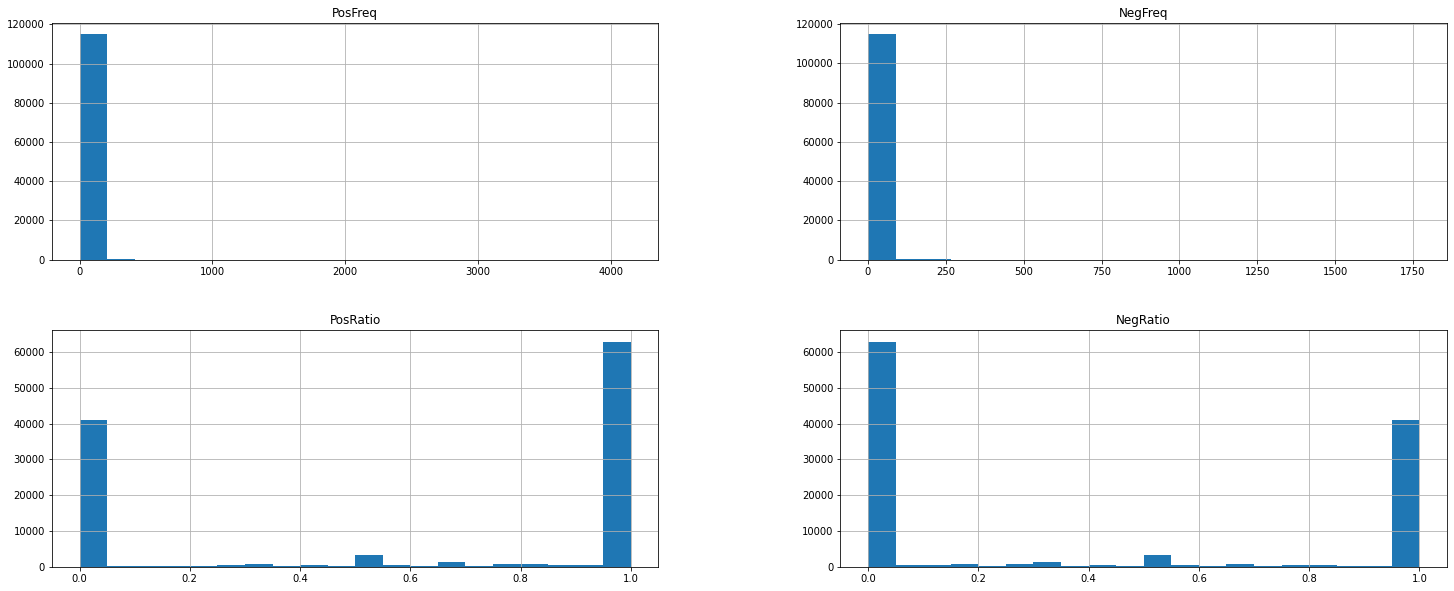

In [13]:
full_df.hist(bins=20, figsize=(25,10))

In [32]:
full_df_highfreq = full_df[(full_df.PosFreq>100) | (full_df.NegFreq>100)]
full_df_highfreq.describe()

,PosFreq,NegFreq,PosRatio,NegRatio
count,244.000000,244.000000,244.000000,244.000000
mean,237.659836,128.569672,0.584393,0.415607
std,448.695882,203.225045,0.382221,0.382221
min,0.000000,0.000000,0.000000,0.000000
25%,20.750000,19.000000,0.105221,0.077572
50%,129.500000,81.500000,0.764305,0.235695
75%,241.250000,167.250000,0.922428,0.894779
max,4149.000000,1771.000000,1.000000,1.000000


In [33]:
matched_df = full_df_highfreq[full_df_highfreq.index.isin(hashtag_test)]
matched_df

,PosFreq,NegFreq,PosRatio,NegRatio
Hashtag,,,,
10,31.0,214.0,0.126531,0.873469
1dfamily,306.0,95.0,0.763092,0.236908
askzacefron,289.0,9.0,0.969799,0.030201
believe,699.0,358.0,0.661306,0.338694
bestfriend,120.0,38.0,0.759494,0.240506
...,...,...,...,...
yay,235.0,32.0,0.880150,0.119850
yolo,552.0,146.0,0.790831,0.209169
yougetmajorpoints,558.0,2.0,0.996429,0.003571


In [34]:
matched_df.describe()

,PosFreq,NegFreq,PosRatio,NegRatio
count,121.000000,121.000000,121.000000,121.000000
mean,324.371901,165.694215,0.572849,0.427151
std,605.184037,258.172838,0.368941,0.368941
min,0.000000,0.000000,0.000000,0.000000
25%,31.000000,27.000000,0.130952,0.109524
50%,166.000000,113.000000,0.738516,0.261484
75%,306.000000,192.000000,0.890476,0.869048
max,4149.000000,1771.000000,1.000000,1.000000


array([[<AxesSubplot:title={'center':'PosFreq'}>,
        <AxesSubplot:title={'center':'NegFreq'}>],
       [<AxesSubplot:title={'center':'PosRatio'}>,
        <AxesSubplot:title={'center':'NegRatio'}>]], dtype=object)

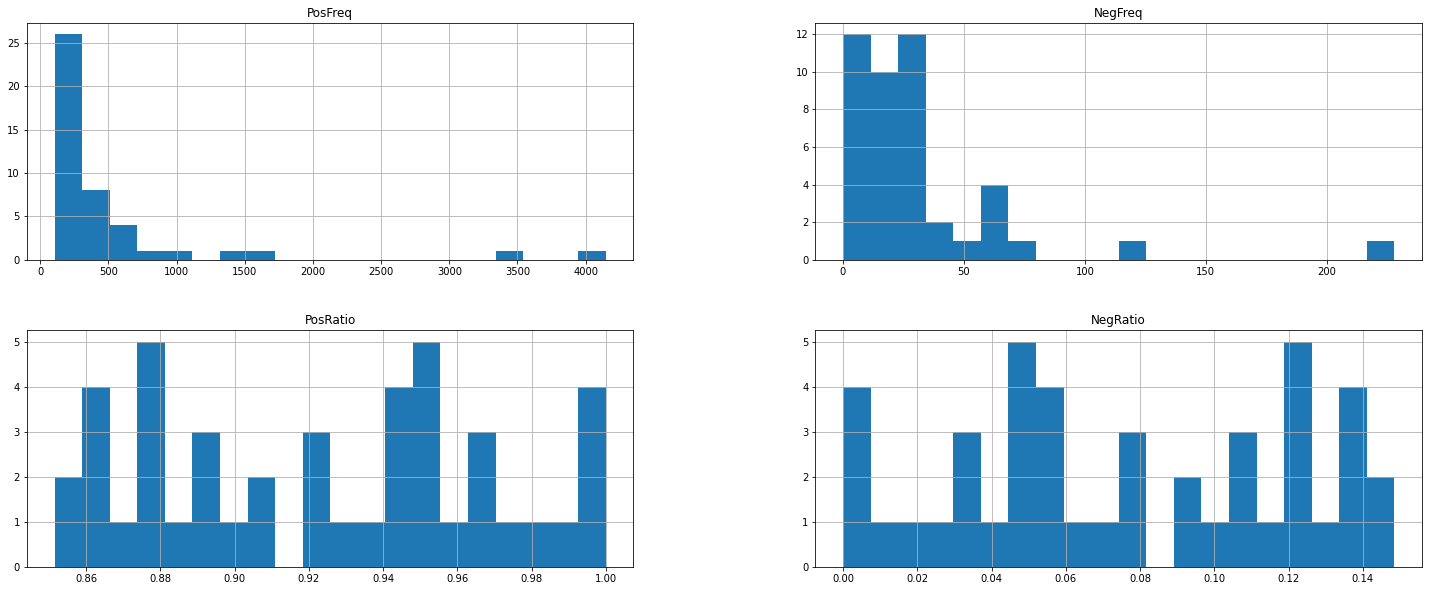

In [44]:
matched_pos = matched_df[matched_df.PosRatio>0.85]
matched_pos.hist(bins=20, figsize=(25,10))

array([[<AxesSubplot:title={'center':'PosFreq'}>,
        <AxesSubplot:title={'center':'NegFreq'}>],
       [<AxesSubplot:title={'center':'PosRatio'}>,
        <AxesSubplot:title={'center':'NegRatio'}>]], dtype=object)

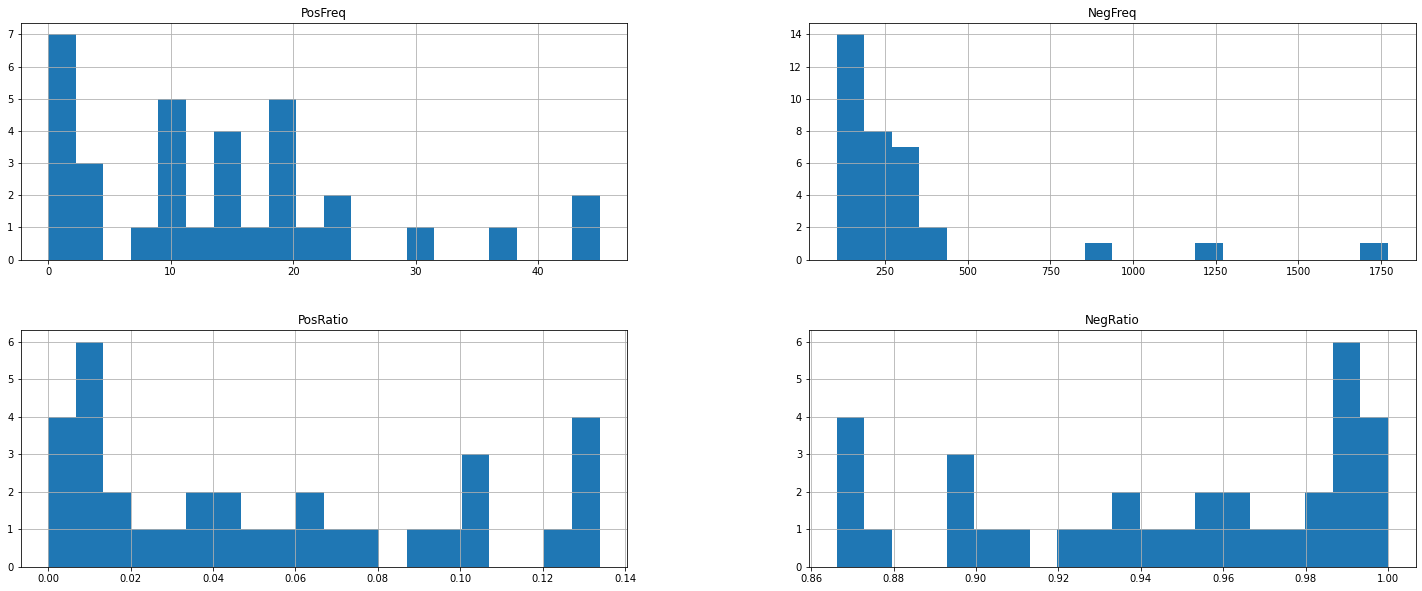

In [46]:
matched_neg = matched_df[matched_df.NegRatio>0.85]
matched_neg.hist(bins=20, figsize=(25,10))

In [47]:
#TODO: Slang?

# Length Exploration

# PoS Exploration

# Consecutive Repeating Words Exploration